**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ sklearn 0.20.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [2]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [4]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Предобработка данных

#### Обучение и отложенный тест

In [6]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [7]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [8]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [13]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 10) (1000, 14)


In [10]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [11]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [12]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [14]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [15]:
categorical_data_columns = ['season', 'weather', 'month'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [16]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [17]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [18]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


### Pipeline

In [19]:
regressor = linear_model.SGDRegressor(random_state = 0, max_iter = 3, loss = 'squared_loss', penalty = 'l2')

In [20]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [21]:
estimator.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001EBCD6B6678>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
     

In [22]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

120.17177172806856

### Подбор параметров

In [23]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_processing', 'model_fitting', 'feature_processing__n_jobs', 'feature_processing__transformer_list', 'feature_processing__transformer_weights', 'feature_processing__verbose', 'feature_processing__binary_variables_processing', 'feature_processing__numeric_variables_processing', 'feature_processing__categorical_variables_processing', 'feature_processing__binary_variables_processing__accept_sparse', 'feature_processing__binary_variables_processing__check_inverse', 'feature_processing__binary_variables_processing__func', 'feature_processing__binary_variables_processing__inv_kw_args', 'feature_processing__binary_variables_processing__inverse_func', 'feature_processing__binary_variables_processing__kw_args', 'feature_processing__binary_variables_processing__pass_y', 'feature_processing__binary_variables_processing__validate', 'feature_processing__numeric_variables_processing__memory', 'feature_processing__numeric_variables_processing__steps', 

In [24]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [25]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [26]:
%%time
grid_cv.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; f

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_mask = np.ones((n_samples, n_features), dtype=np.bool)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more d

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_mask = np.ones((n_samples, n_features), dtype=np.bool)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more d

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Wall time: 727 ms


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function <lambda> at 0x000001EBCD6B6678>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                      

In [27]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-106.60193979729921
{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.05}


### Оценка по отложенному тесту

In [28]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

In [29]:
metrics.mean_absolute_error(test_labels, test_predictions)

125.11055616822885

In [30]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [31]:
print(test_predictions[:20])

[153.28859124 181.89867268 227.64068051 262.47727954 278.91095558
 279.82091706 301.6223314  333.35079391 336.28447325 348.55425173
 346.29477487 336.77206344 318.29674096 298.65247956 285.35831745
 246.0338046  252.72004984  58.96734361  66.43816405  73.90898448]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

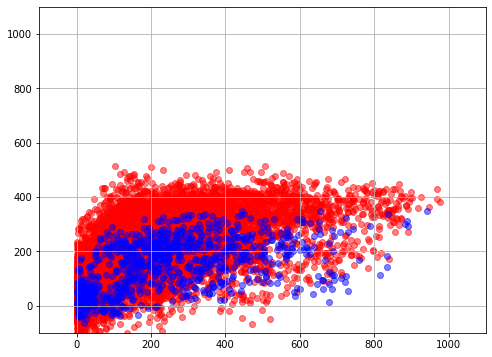

In [32]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [33]:
from sklearn.ensemble import RandomForestRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Progra

In [34]:
regressor = RandomForestRegressor(random_state = 0, max_depth = 20, n_estimators = 50)

In [35]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [36]:
estimator.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001EBCF987288>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
     

In [37]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

79.49758619912876

In [38]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [39]:
estimator.predict(test_data)[:10]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.61615818, 317.85774486,
       280.98963263, 434.51333333])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Text(0.5, 1.0, 'random forest model')

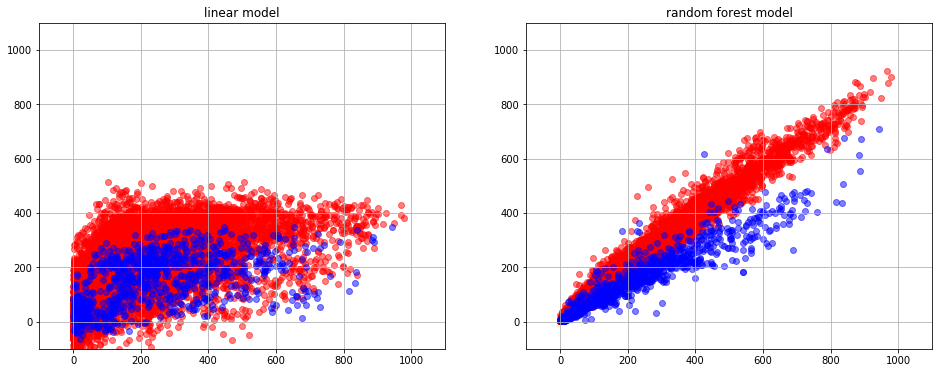

In [40]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

In [41]:
from sklearn.neighbors import KNeighborsRegressor

In [42]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance', n_jobs=5)

In [43]:
pipe_knn = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', knn)
    ]
)

In [44]:
pipe_knn.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001EBD2BD1048>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
     

In [45]:
metrics.mean_absolute_error(test_labels, pipe_knn.predict(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

109.34120400615747

In [46]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [47]:
np.round(pipe_knn.predict(test_data)[:10], 1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

array([374.9, 357. , 247.9, 291.6, 350.2, 403.4, 209.4, 557.1, 485.1,
       611.3])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Text(0.5, 1.0, 'kNN, k=5 model')

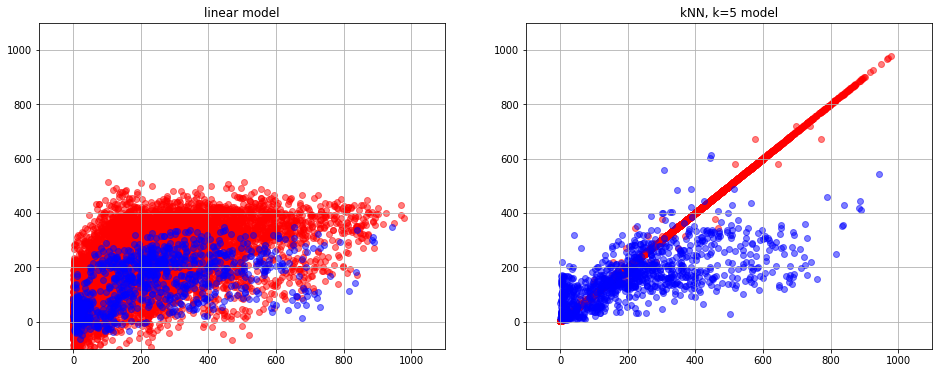

In [48]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, pipe_knn.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipe_knn.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('kNN, k=5 model')

In [49]:
from sklearn.svm import LinearSVR

In [50]:
svr = LinearSVR(random_state=0, tol=1e-5)

pipe_svr = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', svr)
    ]
)

In [51]:
pipe_svr.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001EBD2A6F5E8>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
     

In [52]:
metrics.mean_absolute_error(test_labels, pipe_svr.predict(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

129.87363321593986

In [53]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [54]:
np.round(pipe_svr.predict(test_data)[:10], 1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

array([104. , 127.7, 163.1, 191.2, 204.6, 228.8, 224.9, 250.8, 253.8,
       264.8])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Text(0.5, 1.0, 'SVM Regression model')

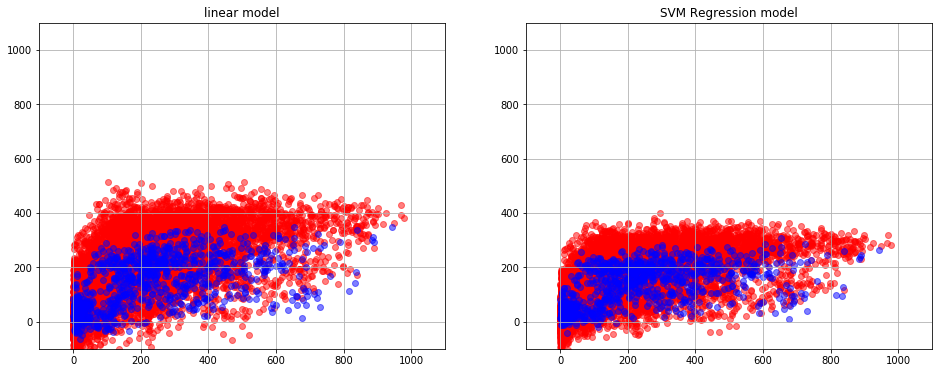

In [55]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, pipe_svr.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipe_svr.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('SVM Regression model')

In [56]:
from sklearn.tree import DecisionTreeRegressor

In [57]:
trees = DecisionTreeRegressor(random_state=0)

pipe_tree = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', trees)
    ]
)

In [58]:
pipe_tree.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x000001EBCD4079D8>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     pass_y='deprecated',
                                                                     validate=None)),
                                                ('numeric_variables_processing',
     

In [59]:
metrics.mean_absolute_error(test_labels, pipe_tree.predict(test_data))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

82.715

In [60]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [61]:
np.round(pipe_tree.predict(test_data)[:10], 1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

array([381., 297., 241., 275., 291., 195., 183., 371., 455., 481.])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

Text(0.5, 1.0, 'Tree Regression model')

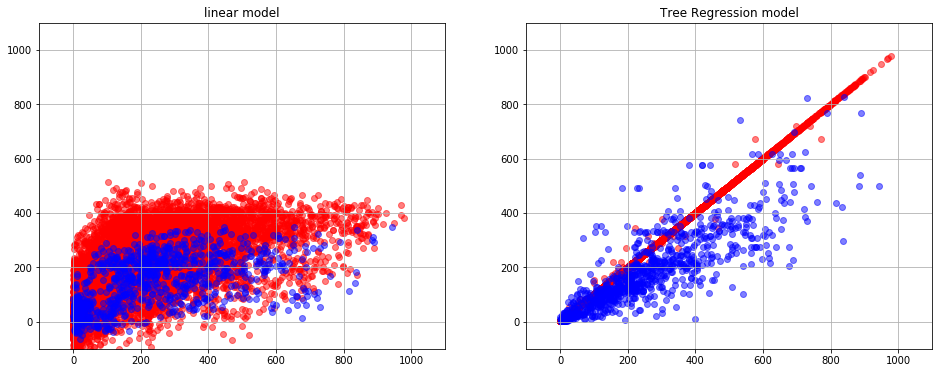

In [62]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, pipe_tree.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipe_tree.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('Tree Regression model')